In [1]:
## import essential modules 
import qumcmc 
from qumcmc.basic_utils import *
from qumcmc.energy_models import IsingEnergyFunction, Exact_Sampling

from qumcmc.classical_mcmc_routines import *
from qumcmc.quantum_mcmc_routines_qulacs import *     #for Qulacs Simulator backend
# from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc   #for qiskit Aer's Simulator backend 
from typing import Union
from qumcmc.trajectory_processing import *
import seaborn as sns

#
import random

In [43]:
res = random.sample(range(1, 50), 7)

In [48]:
def kl_divergence(dict_p: dict, dict_q: dict):
    ''' 
    Returns KL divergence KL(p||q);

    Args:

    dict_p: distribution p ({random_variable: prob}),

    dict_q: distribution q ({random_variable: prob}),

    prelim_check: default 'True'. 
    If user is completely sure that 
    dict_p and dict_q have same keys and that both the distributions are
    normalised then user can set it to 'False'.
    '''
    # if prelim_check:
    #     #check for whether or not dict_p and dict_q have same keys
    #     keys_p,keys_q=list(dict_p.keys()),list(dict_q.keys())# reason why not inplace
    #     keys_p.sort();keys_q.sort()
    #     assert keys_p==keys_q, "keys of both the dictionaries dont match!"

    #     # check for whether values add to 1.
    #     eps=1e-6
    #     sum_vals_p=np.sum(list(dict_p.values()))
    #     assert np.abs(sum_vals_p-1.0)<=eps, "sum of values of dict_p must be 1."
    #     sum_vals_q=np.sum(list(dict_q.values()))
    #     assert np.abs(sum_vals_q-1.0)<=eps, "sum of values of dict_q must be 1."
    
    # #prep for caln
    # p=DiscreteProbabilityDistribution(dict_p).index_sorted_dict()
    # q=DiscreteProbabilityDistribution(dict_q).index_sorted_dict()
    # p_arr,q_arr=np.array(list(p.values())).reshape((len(p))), np.array(list(q.values())).reshape((len(q)))
    # return np.sum(np.where(p_arr>10**-6,p_arr*np.log2(p_arr/q_arr),0.))

    KL = 0
    for bitstring, p_data in dict_p.items():
        if bitstring in dict_q.keys() and p_data!=0:
            KL += p_data * np.log(p_data) - p_data * np.log(
                max(1e-6, dict_q[bitstring])
            )
            # print("1. kl is:",p_data * np.log(p_data) - p_data * np.log(
            #     max(1e-6, dict_q[bitstring])))
        elif bitstring in dict_q.keys() and p_data==0:
            KL+=0
        else:
            KL += p_data * np.log(p_data) - p_data * np.log(1e-6)
            #print("2: KL is:",p_data * np.log(p_data) - p_data * np.log(1e-6))
    return KL
    #     else:
    #         KL += p_data * np.log(p_data) - p_data * np.log(1e-6)
    #         print("2: KL is:",p_data * np.log(p_data) - p_data * np.log(1e-6))
    # return KL

def js_divergence(dict_p:dict,dict_q:dict, prelim_check=True):
    ''' 
    Returns JS divergence JS(p||q);
    
    Args:
    dict_p: distribution p ({random_variable: prob}),

    dict_q: distribution q ({random_variable: prob}),

    prelim_check: default 'True'. 
    If user is completely sure that 
    dict_p and dict_q have same keys and that both the distributions are
    normalised then user can set it to 'False'.
    '''
    if prelim_check:
        #check for whether or not dict_p and dict_q have same keys
        keys_p,keys_q=list(dict_p.keys()),list(dict_q.keys())
        keys_p.sort();keys_q.sort()
        assert keys_p==keys_q, "keys of both the dictionaries dont match!"
        
        # check for whether values add to 1.
        eps=1e-6
        sum_vals_p=np.sum(list(dict_p.values()))
        assert np.abs(sum_vals_p-1.0)<=eps, "sum of values of dict_p must be 1."
        sum_vals_q=np.sum(list(dict_q.values()))
        assert np.abs(sum_vals_q-1.0)<=eps, "sum of values of dict_q must be 1."

    #prep for caln
    p=DiscreteProbabilityDistribution(dict_p).index_sorted_dict()
    q=DiscreteProbabilityDistribution(dict_q).index_sorted_dict()
    p_arr,q_arr=np.array(list(p.values())).reshape((len(p))), np.array(list(q.values())).reshape((len(q)))
    val_m = np.round(0.5 * (p_arr + q_arr),decimals=8)
    #print("val_m:");print(val_m)
    m=dict(zip(list(p.keys()),val_m))
    print("m:");print(m)
    return 0.5 * (kl_divergence(p, m) +  kl_divergence(q, m ))

In [15]:
dict_p={0:0.45,1:0.51,2:0.04}
dict_q={0:0.45,1:0.54,2:0.01}
print("KL:",kl_divergence(dict_p=dict_p,dict_q=dict_q))# correct one with 10^(-20)
print("JS:",js_divergence(dict_p=dict_p,dict_q=dict_q))# correct one with 10^(-20)

1. kl is: 0.0
1. kl is: -0.029150791058373815
1. kl is: 0.055451774444795626
KL: 0.02630098338642181
1. kl is: 0.0
1. kl is: -0.014783643805358737
1. kl is: 0.018800145169829446
1. kl is: 0.0
1. kl is: 0.015212273562015988
1. kl is: -0.009162907318741545
JS: 0.005032933803872576


In [42]:
dict_p={0:0.45,1:0.51,2:0.04}
dict_q={0:0.45,1:0.55}
print("KL:",kl_divergence(dict_p=dict_p,dict_q=dict_q))# with 10^(-20)
dict_q={0:0.45,1:0.55,2:0}
print("JS:",js_divergence(dict_p=dict_p,dict_q=dict_q))# with 10^(-20)

1. kl is: 0.0
1. kl is: -0.038508851779154085
2: KL is: 0.423865389323843
KL: 0.3853565375446889
m:
{0: 0.45, 1: 0.53, 2: 0.02}
1. kl is: 0.0
1. kl is: -0.019617803222176045
1. kl is: 0.027725887222397827
1. kl is: 0.0
1. kl is: 0.02037269942419201
JS: 0.014240391712206896


In [8]:
dict_p={0:0.45,1:0.51,2:0.04}
dict_q={0:0.45,1:0.55}
kl_divergence(dict_p=dict_p,dict_q=dict_q)# 10^(-10)

1. kl is: 0.0
1. kl is: -0.038508851779154085
2: KL is: 0.7922790042028903


0.7537701524237362

In [6]:
dict_p={0:0.45,1:0.51,2:0.04}
dict_q={0:0.45,1:0.55}
kl_divergence(dict_p=dict_p,dict_q=dict_q)# 10^(-6)

1. kl is: 0.0
1. kl is: -0.038508851779154085
2: KL is: 0.423865389323843


0.3853565375446889

In [4]:
a=[1,2,3,4,5]
a[2:]

[3, 4, 5]

            MODEL : my_model
Non-zero Interactions (J) : 6 / 6
Non-zero Bias (h) : 3 / 4
---------------------------------------------
Average Interaction Strength <|J|> :  0.5205
Average Bias Strength <|h|>:  0.2425
alpha :  0.9929399759718381
---------------------------------------------


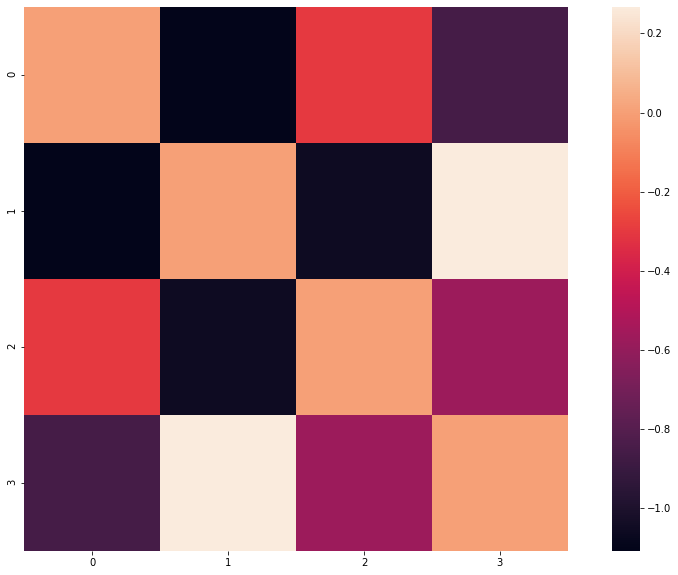

In [62]:
# define the model
np.random.seed(2) ##l lucky-seed: 610358
n_spins = 4

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)

## defining J matrix (mutual 1-1 interaction)
# J =  np.round(np.random.choice([+1, 0, -1], size=(n_spins, n_spins)), decimals=2) 
J =  np.random.uniform(low= -2, high= 2, size= shape_of_J )

J = 0.5 * (J + J.transpose() )
J = np.round( J - np.diag(np.diag(J)) , decimals= 3)

# defining h
h = np.round(0.5 * np.random.randn(n_spins), decimals=2)
#h = np.round(np.random.uniform(low= -1, high = 1, size= (n_spins)), decimals=2)

# instantiate the model
model = IsingEnergyFunction(J, h, name= 'my_model')

model.model_summary()
## set current beta
beta = 2

## run exact sampling over all possible configurations 
esm = Exact_Sampling(model, beta)
# esm.run_exact_sampling(beta)

     MODEL : my_model |  beta : 2
Num Most Probable States : 2
Entropy : 1.0155590341443856
---------------------------------------------


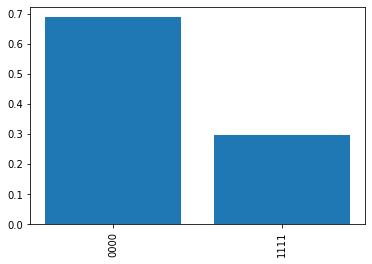

In [63]:
esm.sampling_summary()

In [ ]:
esm.boltzmann_pd

In [65]:
cl_mcmc_chain=classical_mcmc(n_hops=500000,
model=model,temperature=1/beta,initial_state='0000',
)

In [66]:
q_mcmc_chain=quantum_enhanced_mcmc(n_hops=20000,
model=model,temperature=1/beta,
)

In [67]:
cl_sampling=dict(cl_mcmc_chain.emp_distn_markov_chain_dict(normalize=True))
q_sampling=dict(q_mcmc_chain.emp_distn_markov_chain_dict(normalize=True))

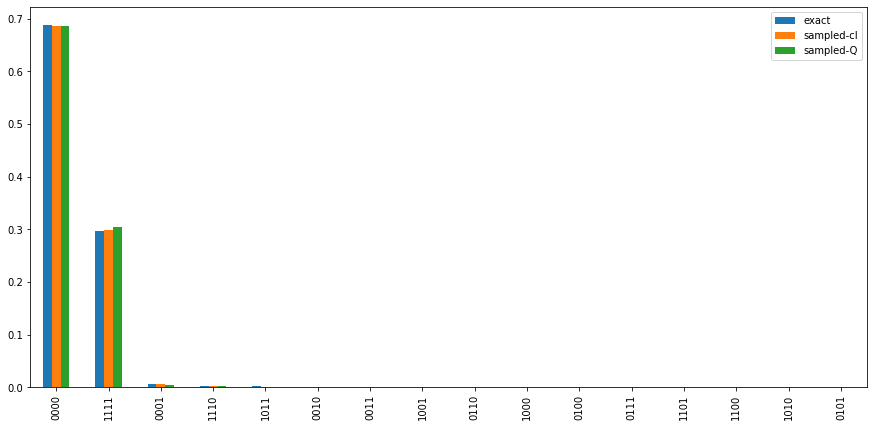

In [68]:
plot_multiple_bargraphs([esm.boltzmann_pd,cl_sampling,q_sampling],["exact","sampled-cl","sampled-Q"],list_normalise=[False,False,False],plot_first_few=20)

In [69]:
cl_accepted=dict(cl_mcmc_chain.get_accepted_dict(normalize=True))
q_accepted=dict(q_mcmc_chain.get_accepted_dict(normalize=True))

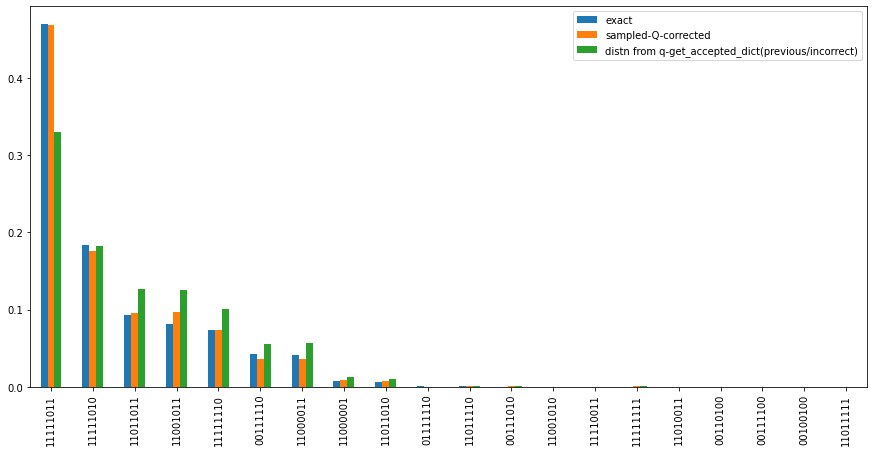

In [32]:
plot_multiple_bargraphs([esm.boltzmann_pd,q_sampling,q_accepted],
["exact","sampled-Q-corrected","distn from q-get_accepted_dict(previous/incorrect)"],
list_normalise=[False,False,False],plot_first_few=20)

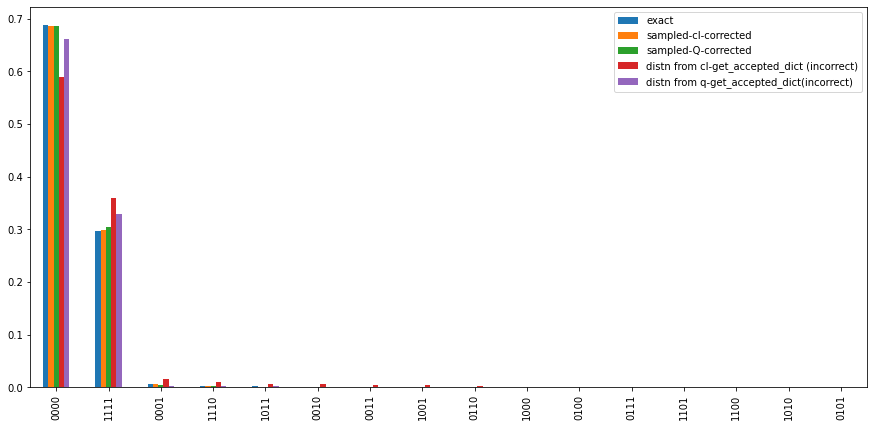

In [70]:
plot_multiple_bargraphs([esm.boltzmann_pd,cl_sampling,q_sampling,cl_accepted,q_accepted],
["exact","sampled-cl-corrected","sampled-Q-corrected","distn from cl-get_accepted_dict (incorrect)","distn from q-get_accepted_dict(incorrect)"],
list_normalise=[False,False,False,False,False],plot_first_few=20)

In [73]:
# steps = 10000
# cl_chain =classical_mcmc(
#     n_hops=steps,
#     model=model,
#     temperature=1/beta,
# )
# steps = 1000
# qamcmc_chain =quantum_enhanced_mcmc(
#     n_hops=steps,
#     model=model,
#     temperature=1/beta,
#     verbose = False
# )

In [74]:
# class IsingEnergyFunction:
#     """ A class to build the Ising Energy Function from data  
#     """

#     def __init__(self, J: np.array, h: np.array, name:str = None) -> None:
#         """
#             ARGS:
#             ----
#             J: weight-matrix of the interactions between the spins 
#             h: local field to the spins 

#         """
#         self.J = J
#         self.h = h
#         # self.beta = beta
#         self.num_spins = len(h)
#         # self.exact_sampling_status = False
#         self.alpha = np.sqrt(self.num_spins) / np.sqrt( sum([J[i][j]**2 for i in range(self.num_spins) for j in range(i)]) + sum([h[j]**2 for j in range(self.num_spins)])  )

#         if name == None: 
#             self.name = 'JK_random'
#         else : self.name = name 
    
#     @property
#     def get_J(self):
#         return self.J
    
#     @property
#     def get_h(self):
#         return self.h

#     # @property
#     def model_summary(self, plot= True) :
        
#         print("=============================================")
#         print("            MODEL : "+str(self.name) )
#         print("=============================================")
        
        
#         print("Non-zero Interactions (J) : "+ str( int(np.count_nonzero(self.J) /2)) + ' / '+str( int( 0.5 * self.num_spins * (self.num_spins - 1))) )
#         print("Non-zero Bias (h) : "+ str( int(np.count_nonzero(self.h) )) + ' / ' + str( self.num_spins ) )
#         print("---------------------------------------------")

#         print("Average Interaction Strength <|J|> : ", np.mean(np.abs(self.J)))
#         print("Average Bias Strength <|h|>: ", np.mean(np.abs(self.h)))
#         print("alpha : ", self.alpha )
    
#         print("---------------------------------------------")


#         # sns.set()
#         if plot:
#             plt.figure(figsize=(16,10))
#             sns.heatmap(self.J, square= True, annot= False, cbar= True)
            

#     def get_energy(self, state: Union[str, np.array]) -> float:
#         """ Returns the energy of a given state

#             ARGS:
#             ----
#             state : configuration of spins for which the energy is requrieed to be calculated.
#                     NOTE:  if input is an numpy array then it should only consist of bipolar values -> {+1, -1}

#         """

#         if isinstance(state, str):
#             state = np.array([-1 if elem == "0" else 1 for elem in state])
#             # state = np.array( [int(list(state)[i]) for i in range(len(state))])
#             energy = 0.5 * np.dot(state.transpose(), self.J.dot(state)) + np.dot(
#                 self.h.transpose(), state
#             )
#             return energy
#         else:
#             return 0.5 * np.dot(state.transpose(), self.J.dot(state)) + np.dot(
#                 self.h.transpose(), state
#             )


#     def get_boltzmann_factor(
#         self, state: Union[str, np.array], beta: float = 1.0
#     ) -> float:

#         """ Get un-normalised boltzmann probability of a given state 

#             ARGS:
#             ----
#             state : configuration of spins for which probability is to be calculated 
#             beta : inverse temperature (1/T) at which the probability is to be calculated.
        
#         """
#         return np.exp(-1 * beta * self.get_energy(state))
    
#     from typing import List
#     def _update_J(self, new_param:float, index: Union[tuple, List]):

#         assert len(index) == 2
#         self.J[index[0], index[1]] = new_param
#         self.J[index[1], index[0]] = new_param
    
#     def _update_h(self, new_param: float, index: int):

#         self.h[index] = new_param

# class DiscreteProbabilityDistribution(dict):
#     """ A class for handling discrete probability distributions """

#     def __init__(self, distribution:dict) -> None :

#         super().__init__(distribution) 
    
#     def _normalise(self, print_normalisation:bool= False):
#         """ Normalise the given disribution 
#             NOTE: works inplace 
#         """
        
#         r_sum = np.sum(list(self.values()))
#         if print_normalisation : print('Normalisation : ', r_sum)
#         for k in list(self.keys()) :
#             self[k] = self[k] / r_sum

#     def value_sorted_dict(self, reverse=False):
#         """ Sort the dictionary in ascending or descending(if reverse=True) order of values. """
#         sorted_dict = {
#             k: v
#             for k, v in sorted(self.items(), key=lambda item: item[1], reverse=reverse)
#         }
#         return sorted_dict

#     def index_sorted_dict(self, reverse= False):
#         """ Sort the dictionary in ascending or descending(if reverse=True) order of index. """
#         sorted_dict = {
#             k: v
#             for k, v in sorted(self.items(), key=lambda item: item[0], reverse=reverse)
#         }
#         return sorted_dict
   
#     def get_truncated_distribution(self, epsilon:float = 0.00001, inplace:bool = False):
        
#         return_dict = {}
#         index_probable_elements = [ indx for indx, b in enumerate( np.array(list(self.values())) > epsilon ) if b ]
#         states = list(self.keys())
#         probs = list(self.values())

#         for indx in index_probable_elements:
#             return_dict[states[indx]] = probs[indx]
        
#         if not inplace:
#             return DiscreteProbabilityDistribution(return_dict)
#         else :
#             self.__init__(return_dict)
            
#     def expectation(self, dict_observable_val_at_states: dict):
#         """
#         new version:
#         Returns average of any observable of interest

#         Args:
#         self= {state: probability}
#         dict_observable_val_at_states={state (same as that of self): observable's value at that state}

#         Returns:
#         avg
#         """
#         ##TODO: A faster implementation is possible by using numpy 
#         len_dict = len(self)
#         temp_list = [
#             self[j] * dict_observable_val_at_states[j]
#             for j in (list(self.keys()))
#         ]
#         avg = np.sum(
#             temp_list
#         )  # earlier I had np.mean here , which is wrong (obviously! duh!)
#         return avg

#     def get_entropy(self):
#         tmp = sorted(np.array(list(self.values())), reverse= True)
#         entropy = 0
#         for val in tmp :
#             if val > 0.00001 :
#                 entropy += -1 * val * np.log2(val)
#             else: 
#                 return entropy
    
#     def get_observable_expectation(self, observable) -> float:
#         """ Return expectation value of a classical observables

#             ARGS :
#             ----
#             observable: Must be a function of the spin configuration which takes an 'np.array' / 'str' of binary elements as input argument and returns a 'float'
#             beta: inverse temperature

#         """
#         # all_configs = np.array(list(itertools.product([1, 0], repeat=self.num_spins)))
#         # all_configs = [f"{k:0{self.num_spins}b}" for k in range(0, 2 ** (self.num_spins))]
        

#         return np.sum(
#             [
#                 self[config]
#                 * observable(config)

#                 for config in self.keys()
#             ]
#         )



#### HELPER FUNCTIONS

In [46]:
int_to_binary = lambda state_obtained, n_spins : f"{state_obtained:0{n_spins}b}"
binary_to_bipolar = lambda string : 2.0 * float(string) - 1.0

def get_observable_expectation(observable: callable, mcmc_chain: MCMCChain, skip_init:int= 100) :

    sample_observable = []
    for s in mcmc_chain.accepted_states :

        sample_observable.append(observable(s) )
    
    sample_observable = np.array(sample_observable)
        
    return sample_observable.mean(dtype= float)#, sample_observable.var(dtype= float)


def correlation_spins(state: str, indices : Union[tuple, List] ):

    assert len(indices) <= len(state)
    
    
    prod = 1.0
    for j in indices :
        prod *= binary_to_bipolar(state[j])

    return prod

def cd_J(index, data_distribution:DiscreteProbabilityDistribution, mcmc_chain: MCMCChain):

    assert len(index) == 2
    observable = lambda s: correlation_spins(s, [index[0], index[1]])
    r = data_distribution.get_observable_expectation(observable) - get_observable_expectation(observable, mcmc_chain, skip_init= 100)

    return r

def cd_h(index:int, data_distribution:DiscreteProbabilityDistribution, mcmc_chain: MCMCChain):

    assert isinstance(index, int)
    observable = lambda s: correlation_spins(s, [index])
    r = data_distribution.get_observable_expectation(observable) - get_observable_expectation(observable, mcmc_chain, skip_init= 100)

    return r

#### Class for Training

In [39]:
from copy import deepcopy

In [40]:
import pandas as pd

In [41]:
# @dataclass
class cd_training():
    ''' 
    model: initial model = (J init, h init) at some temp T
    beta: 1/Temperature
    data_dist: empirical data which we want to learn!
    
    '''

    def __init__(self, model: IsingEnergyFunction, beta:float ,data_dist: DiscreteProbabilityDistribution) -> None:
        self.model = deepcopy(model)
        self.model_beta = beta
        self.data_distribution = data_dist
        self.training_history = {}
        self.list_pair_of_indices=[[i,j] for i in range(1,self.model.num_spins) for j in range(i,self.model.num_spins) if j!=i]
        

    def cd_J(self, index, mcmc_chain: MCMCChain):

        assert len(index) == 2
        observable = lambda s: correlation_spins(s, [index[0], index[1]])
        r = self.data_distribution.get_observable_expectation(observable) - get_observable_expectation(observable, mcmc_chain, skip_init= 100)

        return r

    def cd_h(self, index:int, mcmc_chain: MCMCChain):

        assert isinstance(index, int)
        observable = lambda s: correlation_spins(s, [index])
        r = self.data_distribution.get_observable_expectation(observable) - get_observable_expectation(observable, mcmc_chain, skip_init= 100)

        return r

    # @setattr
    # def data_distribution()
    
    def _train_on_mcmc_chain(self, lr:float= 0.01, 
    method = 'quantum-enhanced', 
    iterations: int = 100, # rename this iterations to something else
    num_random_Jij: int=10,
    mcmc_steps:int =1000 ):# we will try to increase mcmc steps. 

        if method == 'quantum-enhanced' :
            self.mcmc_chain = quantum_enhanced_mcmc(
            n_hops=mcmc_steps,
            model=self.model,
            temperature=1/self.model_beta,
            verbose= False
            )
        elif method == 'classical-uniform' : 
            self.mcmc_chain = classical_mcmc(
            n_hops=mcmc_steps,
            model=self.model,
            temperature=1/self.model_beta,
            verbose= False
            )
        
        ## random update strategy ##
        ## just realised that even this is not a good thing! 
        assert iterations<=self.model.num_spins, f"iterations should be <= num_spins (which is= {self.model.num_spins}) "
        assert num_random_Jij<=len(self.list_pair_of_indices), f"num_random_Jij should be <=len(self.list_pair_of_indices) (which is= {len(self.list_pair_of_indices)})"
        
        list_random_indices=random.sample(range(0,self.model.num_spins), iterations)
        #list_pair_of_indices=[[i,j] for i in range(1,self.model.num_spins) for j in range(i,self.model.num_spins) if j!=i]
        #list_pair_of_different_indices=random.sample(self.list_pair_of_indices,k=num_random_Jij)

        list_pair_of_different_indices=[[list_random_indices[j],
                    random.choice(list(range(0,list_random_indices[j]))+list(range(list_random_indices[j]+1,self.model.num_spins)))] 
                    for j in range(0,iterations)]
        
        # ## Update J
        for k in range(len(list_pair_of_different_indices)):
            indices_J=list_pair_of_different_indices[k]
            updated_param_j=model.J[indices_J[0],indices_J[1]] - lr * self.cd_J(indices_J, self.mcmc_chain)
            self.model._update_J(updated_param_j, indices_J)

        for k in range(iterations):
            #indices_J=list_pair_of_different_indices[k]
            #updated_param_j = model.J[indices_J[0],indices_J[1]] - lr * self.cd_J(indices_J, self.mcmc_chain)

            # update h
            index_h=list_random_indices[k]
            updated_param_h=model.h[index_h] - lr*self.cd_h(index_h,self.mcmc_chain)

            #self.model._update_J(updated_param_j, indices_J)
            self.model._update_h(updated_param_h, index_h)

        # for _ in range(iterations):
            
        #     ## update J ##
        #     index_J = [np.random.randint(0, self.model.num_spins), np.random.randint(0, self.model.num_spins)]

        #     updated_param_j = model.J[index_J[0], index_J[1]] - lr * self.cd_J(index_J, self.mcmc_chain) 
        #     ## comment by neel: we need to update both Jij as well as Jji
        #     # already updating J first.
        #     #self.model._update_J(updated_param_j, index)

        #     ## update h ##
        #     index_h = np.random.randint(0, self.model.num_spins)

        #     updated_param_h = model.h[index_h] - lr * self.cd_h(index_h, self.mcmc_chain) 

        #     self.model._update_J(updated_param_j, index_J)
        #     self.model._update_h(updated_param_h, index_h)

            

    def train(self, lr:float= 0.01, method = 'quantum-enhanced', 
    epochs:int = 10, iterations: int = 100, num_random_Jij:int=5,
    mcmc_steps:int = 500, show_kldiv:bool = True ):

        ## random update strategy ##
        kl_div = []
        iterator = tqdm(range(epochs), desc= 'training epochs')
        iterator.set_postfix({'method': method})
        for epoch in iterator:

            self._train_on_mcmc_chain(lr= lr , 
            method = method, iterations= iterations, num_random_Jij=num_random_Jij,
            mcmc_steps= mcmc_steps )

            if show_kldiv:

                
                kl_div.append(kl_divergence(  self.data_distribution,self.mcmc_chain.get_accepted_dict(normalize= True)  ))
                iterator.set_postfix( { 'method ': method, 'kl div ' : kl_div[-1] })
        
        if show_kldiv : self.training_history['kl_div']= kl_div


#### TRIALS

     MODEL : param_model |  beta : 1.0
Num Most Probable States : 4
Entropy : 2.016575422384969
---------------------------------------------


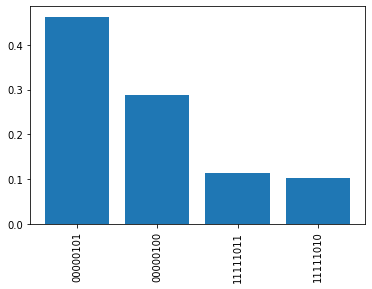

In [42]:
## INITIALISE ANOTHER RANDOM MODEL ##

np.random.seed(1)# should always be in the same cell!  
n_spins = 8

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)

## defining J matrix (mutual 1-1 interaction)
# J =  np.round(np.random.choice([+1, 0, -1], size=(n_spins, n_spins)), decimals=2) 
J =  np.random.uniform(low= -3, high= 3, size= shape_of_J )

J = 0.5 * (J + J.transpose() )
J = np.round( J - np.diag(np.diag(J)) , decimals= 3)

# defining h
h = np.round(0.4 * np.random.randn(n_spins), decimals=2)
#h = np.round(np.random.uniform(low= -1, high = 1, size= (n_spins)), decimals=2)

# instantiate the model
beta_train = 1.0

param_model = IsingEnergyFunction(J, h, name= 'param_model')
param_model_esm = Exact_Sampling(param_model, beta= beta_train)

param_model_esm.sampling_summary()

In [43]:
param_model.get_J # before training

array([[ 0.   ,  0.351, -1.748,  0.536,  0.314,  0.244, -1.578, -0.241],
       [ 0.351,  0.   , -0.066,  1.739, -0.787,  1.879, -2.528, -0.548],
       [-1.748, -0.066,  0.   , -2.151,  1.478,  0.746, -2.002,  0.845],
       [ 0.536,  1.739, -2.151,  0.   , -1.544,  2.002, -0.668,  0.363],
       [ 0.314, -0.787,  1.478, -1.544,  0.   , -0.186, -2.31 , -0.443],
       [ 0.244,  1.879,  0.746,  2.002, -0.186,  0.   ,  0.522, -0.877],
       [-1.578, -2.528, -2.002, -0.668, -2.31 ,  0.522,  0.   , -0.757],
       [-0.241, -0.548,  0.845,  0.363, -0.443, -0.877, -0.757,  0.   ]])

     MODEL : my_model |  beta : 2
Num Most Probable States : 9
Entropy : 2.6583738777945
---------------------------------------------


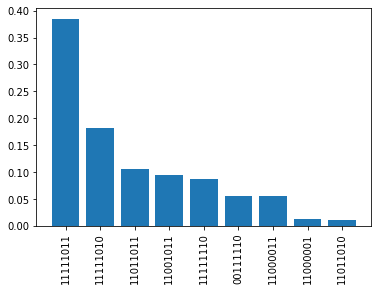

In [44]:
## COMPARE WITH THE DATA-DISTRIBUTION ##
esm.sampling_summary()

#### TRAINING

In [44]:
num_spins_prob=model.num_spins

In [54]:
training_quantum = cd_training(param_model, beta_train, esm.boltzmann_pd)
training_quantum.train(lr = 0.05 ,method = 'quantum-enhanced' , 
epochs= 60, iterations= num_spins_prob,num_random_Jij=num_spins_prob ,
mcmc_steps= 1000 , show_kldiv= True)# when i in hi and i in Jij are same

training epochs:  60%|██████    | 36/60 [04:58<03:18,  8.28s/it, method =quantum-enhanced, kl div =0.603]


KeyboardInterrupt: 

In [ ]:
param_model.get_J 

array([[ 0.   ,  0.351, -1.748,  0.536,  0.314,  0.244, -1.578, -0.241],
       [ 0.351,  0.   , -0.066,  1.739, -0.787,  1.879, -2.528, -0.548],
       [-1.748, -0.066,  0.   , -2.151,  1.478,  0.746, -2.002,  0.845],
       [ 0.536,  1.739, -2.151,  0.   , -1.544,  2.002, -0.668,  0.363],
       [ 0.314, -0.787,  1.478, -1.544,  0.   , -0.186, -2.31 , -0.443],
       [ 0.244,  1.879,  0.746,  2.002, -0.186,  0.   ,  0.522, -0.877],
       [-1.578, -2.528, -2.002, -0.668, -2.31 ,  0.522,  0.   , -0.757],
       [-0.241, -0.548,  0.845,  0.363, -0.443, -0.877, -0.757,  0.   ]])

In [56]:
training_cl = cd_training(param_model, beta_train, esm.boltzmann_pd)
training_cl.train(lr = 0.01 ,method = 'classical-uniform' , epochs= 100, 
iterations= num_spins_prob, num_random_Jij=num_spins_prob, mcmc_steps= 1000 , show_kldiv= True)

training epochs: 100%|██████████| 100/100 [00:09<00:00, 10.82it/s, method =classical-uniform, kl div =0.634]


In [26]:
param_model.get_J

array([[ 0.   ,  0.145, -1.045,  1.898,  1.051, -0.026, -0.955, -2.507],
       [ 0.145,  0.   ,  0.394, -0.189, -0.425, -1.743,  0.088,  1.857],
       [-1.045,  0.394,  0.   , -1.355, -0.101,  1.823, -1.042,  0.219],
       [ 1.898, -0.189, -1.355,  0.   ,  1.521, -0.486, -1.106,  0.561],
       [ 1.051, -0.425, -0.101,  1.521,  0.   , -0.681,  0.621,  0.695],
       [-0.026, -1.743,  1.823, -0.486, -0.681,  0.   , -0.192,  1.768],
       [-0.955,  0.088, -1.042, -1.106,  0.621, -0.192,  0.   , -2.836],
       [-2.507,  1.857,  0.219,  0.561,  0.695,  1.768, -2.836,  0.   ]])

##### Compare reconstructed model

In [57]:
# classical reconstructed model
cl_mcmc_chain_after_train=classical_mcmc(n_hops=1000,model=training_cl.model, temperature=1,verbose=False)
cl_reconstructed_distn=cl_mcmc_chain_after_train.emp_distn_markov_chain_dict(normalize=True)
#print(cl_reconstructed_distn)
# quantum reconstructed model
q_mcmc_chain_after_train=quantum_enhanced_mcmc(n_hops=1000, model=training_quantum.model,temperature=1,verbose=False)
q_reconstructed_distn=q_mcmc_chain_after_train.emp_distn_markov_chain_dict(normalize=True)
#print(q_reconstructed_distn)

In [31]:
# classical_reconstructed_model_esm = Exact_Sampling(training_cl.model, beta= beta_train)
# quantum_reconstructed_model_esm = Exact_Sampling(training_quantum.model, beta= beta_train)

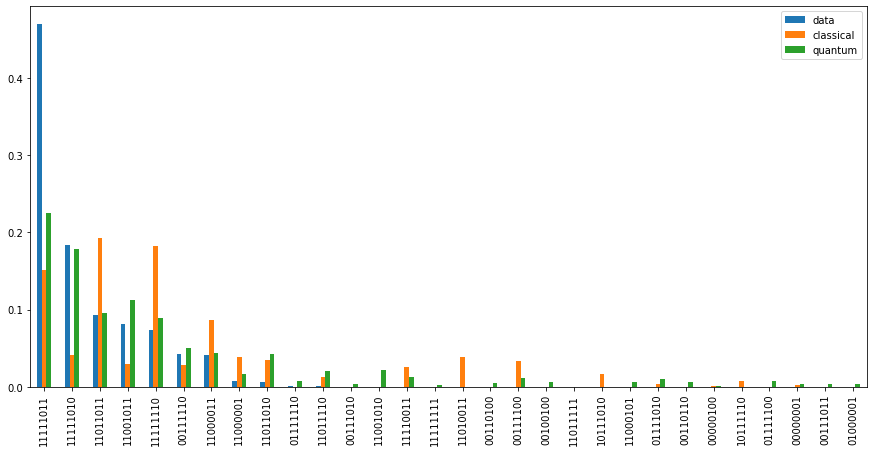

In [59]:
plot_multiple_bargraphs([esm.boltzmann_pd, cl_reconstructed_distn, q_reconstructed_distn],
 ['data','classical', 'quantum'], list_normalise=[False,False,False], plot_first_few= 30)

In [43]:
#plot_multiple_bargraphs([esm.boltzmann_pd, classical_reconstructed_model_esm.boltzmann_pd, quantum_reconstructed_model_esm.boltzmann_pd], ['data','classical', 'quantum'], list_normalise=[False,False,False], plot_first_few= 15)

     MODEL : param_model |  beta : 1.001
Num Most Probable States : 9
Entropy : 2.690821820517544
---------------------------------------------


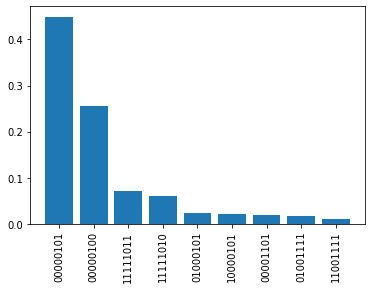

In [92]:
classical_reconstructed_model_esm.sampling_summary()

     MODEL : param_model |  beta : 1.001
Num Most Probable States : 9
Entropy : 2.690821820517544
---------------------------------------------


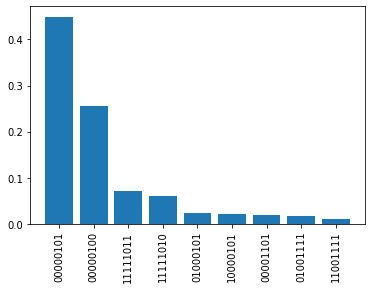

In [93]:
quantum_reconstructed_model_esm.sampling_summary()

In [94]:
training_quantum.mcmc_chain.get_accepted_dict(norma)

NameError: name 'norma' is not defined